First we import everything include the dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import plotly
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import gc

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [23]:
POS_CASH_balance = pd.read_csv("home-credit-default-risk/POS_CASH_balance.csv")
Application_test = pd.read_csv("home-credit-default-risk/application_test.csv")
Application_train = pd.read_csv("home-credit-default-risk/application_train.csv")
Bureau = pd.read_csv("home-credit-default-risk/bureau.csv")
Bureau_balance = pd.read_csv("home-credit-default-risk/bureau_balance.csv")
Credit_card_balance = pd.read_csv("home-credit-default-risk/credit_card_balance.csv")
Installments_payments = pd.read_csv("home-credit-default-risk/installments_payments.csv")
Previous_application = pd.read_csv("home-credit-default-risk/previous_application.csv")
Sample_submission = pd.read_csv("home-credit-default-risk/sample_submission.csv")

First we will feature engineer and dealing with Application Train and Test First

We want to fill missing categorical data by basically fill most frequent values in data

In [24]:
Application_train.isnull().sum().values

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,     12,    278,   1292,      0,      0,      0,      0,
            0,      0,      0,      0,      0, 202929,      0,      0,
            0,      0,      0,      0,  96391,      2,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0, 173378,    660,  60965, 156061, 179943, 150007, 204488,
       214865, 163891, 154828, 153020, 208642, 182590, 210199, 154350,
       213514, 169682, 156061, 179943, 150007, 204488, 214865, 163891,
       154828, 153020, 208642, 182590, 210199, 154350, 213514, 169682,
       156061, 179943, 150007, 204488, 214865, 163891, 154828, 153020,
       208642, 182590, 210199, 154350, 213514, 169682, 210295, 154297,
       148431, 156341, 145755,   1021,   1021,   1021,   1021,      1,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [25]:
Want_to_fill_train = Application_train.iloc[:,Application_train.isnull().sum().values > 0].select_dtypes("object")
Want_to_fill_test = Application_test.iloc[:,Application_test.isnull().sum().values >0].select_dtypes("object")

In [26]:
Want_to_fill_train

,NAME_TYPE_SUITE,OCCUPATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Unaccompanied,Laborers,reg oper account,block of flats,"Stone, brick",No
1,Family,Core staff,reg oper account,block of flats,Block,No
2,Unaccompanied,Laborers,NaN,NaN,NaN,NaN
3,Unaccompanied,Laborers,NaN,NaN,NaN,NaN
4,Unaccompanied,Core staff,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
307506,Unaccompanied,Sales staff,reg oper account,block of flats,"Stone, brick",No
307507,Unaccompanied,NaN,reg oper account,block of flats,"Stone, brick",No
307508,Unaccompanied,Managers,reg oper account,block of flats,Panel,No
307509,Unaccompanied,Laborers,NaN,block of flats,"Stone, brick",No


In [27]:
Want_to_fill_test

,NAME_TYPE_SUITE,OCCUPATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Unaccompanied,NaN,NaN,block of flats,"Stone, brick",No
1,Unaccompanied,Low-skill Laborers,NaN,NaN,NaN,NaN
2,NaN,Drivers,NaN,NaN,NaN,NaN
3,Unaccompanied,Sales staff,reg oper account,block of flats,Panel,No
4,Unaccompanied,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
48739,Unaccompanied,NaN,NaN,NaN,NaN,NaN
48740,Unaccompanied,Sales staff,NaN,NaN,NaN,NaN
48741,Unaccompanied,NaN,NaN,block of flats,"Stone, brick",No
48742,Family,Managers,NaN,block of flats,Panel,No


In [28]:
imp_category = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_category.fit(Want_to_fill_train)


SimpleImputer(strategy='most_frequent')

In [29]:
train_fill = imp_category.fit_transform(Want_to_fill_train)
test_fill = imp_category.fit_transform(Want_to_fill_test)

In [30]:
train_fill = pd.DataFrame(train_fill,columns=Want_to_fill_train.columns)
test_fill = pd.DataFrame(test_fill,columns=Want_to_fill_train.columns)

In [31]:
Application_train.drop(columns = Want_to_fill_train.columns,inplace=True)
Application_test.drop(columns= Want_to_fill_test.columns,inplace=True)
Application_train = pd.concat([Application_train,train_fill],axis=1)
Application_test = pd.concat([Application_test,test_fill],axis=1)

Check missing categorical data again

In [32]:
Want_to_fill_train = Application_train.iloc[:,Application_train.isnull().sum().values > 0].select_dtypes("object")
Want_to_fill_test = Application_test.iloc[:,Application_test.isnull().sum().values >0].select_dtypes("object")

In [33]:
Want_to_fill_train.shape

(307511, 0)

So we do it 

In [34]:
data1 = Application_train.iloc[:,Application_train.isnull().sum().values==0].select_dtypes("object")
series1 = data1.apply(pd.Series.nunique, axis = 0)

list_one_hot_encoder = []
list_label = []
for i in range(len(series1)):
  if series1.values[i] <= 2:
    list_label.append(series1.index[i])
  else:
    list_one_hot_encoder.append(series1.index[i])

In [35]:
enc = OneHotEncoder()
enc.fit(Application_train[list_one_hot_encoder])
category = []
count = 1
for i in enc.categories_:
  for j in i:
    category.append(j)
    count+=1
Category_to_df = enc.transform(Application_train[list_one_hot_encoder]).toarray()
Category_to_df = pd.DataFrame(Category_to_df,columns=category)

In [36]:
label_df = Application_train[list_label]
label_df.loc[label_df.NAME_CONTRACT_TYPE == "Cash loans","NAME_CONTRACT_TYPE"] = 0
label_df.loc[label_df.NAME_CONTRACT_TYPE == "Revolving loans","NAME_CONTRACT_TYPE"] = 1
label_df.loc[label_df.FLAG_OWN_CAR == "Y","FLAG_OWN_CAR"] = 1
label_df.loc[label_df.FLAG_OWN_CAR == "N","FLAG_OWN_CAR"] = 0
label_df.loc[label_df.FLAG_OWN_REALTY == "Y","FLAG_OWN_REALTY"] = 1
label_df.loc[label_df.FLAG_OWN_REALTY == "N","FLAG_OWN_REALTY"] = 0
Category_to_df=pd.concat([Category_to_df,label_df],axis=1)

In [37]:
data1 = Application_test.iloc[:,Application_test.isnull().sum().values==0].select_dtypes("object")
series2 = data1.apply(pd.Series.nunique, axis = 0)

In [38]:
lable_df = Application_test[list_label]
lable_df

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,Cash loans,N,Y,No
1,Cash loans,N,Y,No
2,Cash loans,Y,Y,No
3,Cash loans,N,Y,No
4,Cash loans,Y,N,No
...,...,...,...,...
48739,Cash loans,N,Y,No
48740,Cash loans,N,N,No
48741,Cash loans,Y,Y,No
48742,Cash loans,N,N,No


In [39]:
label_df = Application_test[list_label]
label_df.loc[label_df.NAME_CONTRACT_TYPE == "Cash loans","NAME_CONTRACT_TYPE"] = 0
label_df.loc[label_df.NAME_CONTRACT_TYPE == "Revolving loans","NAME_CONTRACT_TYPE"] = 1
label_df.loc[label_df.FLAG_OWN_CAR == "Y","FLAG_OWN_CAR"] = 1
label_df.loc[label_df.FLAG_OWN_CAR == "N","FLAG_OWN_CAR"] = 0
label_df.loc[label_df.FLAG_OWN_REALTY == "Y","FLAG_OWN_REALTY"] = 1
label_df.loc[label_df.FLAG_OWN_REALTY == "N","FLAG_OWN_REALTY"] = 0

In [40]:
enc = OneHotEncoder()
enc.fit(Application_test[list_one_hot_encoder])
category = []
for i in enc.categories_:
  for j in i:
    category.append(j)
Category_to_df_test = enc.transform(Application_test[list_one_hot_encoder]).toarray()
Category_to_df_test = pd.DataFrame(Category_to_df_test,columns=category)

In [41]:
Category_to_df_test = pd.concat([Category_to_df_test,label_df],axis=1)
Category_to_df_test

,F,M,Businessman,Commercial associate,Pensioner,State servant,Student,Unemployed,Working,Academic degree,...,Mixed,Monolithic,Others,Panel,"Stone, brick",Wooden,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,No
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,No
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,1,1,No
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,No
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,No
48740,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,No
48741,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1,No
48742,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,No


In [42]:
Train_Null_category = Application_train.select_dtypes("object")
Train_Null_category = Train_Null_category.iloc[:,Train_Null_category.isnull().sum().values>0]
Train_Null_category 

""
0
1
2
3
4
...
307506
307507
307508
307509


In [43]:
Test_Null_category = Application_test.select_dtypes("object")
Test_Null_category = Test_Null_category.iloc[:,Test_Null_category.isnull().sum().values>0]
Test_Null_category

""
0
1
2
3
4
...
48739
48740
48741
48742


In [46]:
category_df_train = Category_to_df
category_df_test = Category_to_df_test

In [47]:
columns_drop = [2,5,20]
list_index = []
for i in range(category_df_train.shape[1]):
  if i not in columns_drop:
    list_index.append(i)

In [48]:
category_train = category_df_train.iloc[:,list_index]
category_test = category_df_test

In [49]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Numerical_data_train = Application_train.select_dtypes(include=numerics)
Numerical_data_test = Application_test.select_dtypes(include=numerics)
Y_train = Application_train.TARGET

In [50]:
Application_train.loc[Application_train['DAYS_EMPLOYED'] == 365243,"DAYS_EMPLOYED"] = np.nan 
Application_test.loc[Application_test['DAYS_EMPLOYED'] == 365243,"DAYS_EMPLOYED"] = np.nan 

In [51]:
Application_train.OWN_CAR_AGE.fillna(0,inplace=True)
Application_test.OWN_CAR_AGE.fillna(0,inplace=True)

In [52]:
columns = ['AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR']
for i in columns:
  Application_train[i].fillna(0,inplace=True)
  Application_test[i].fillna(0,inplace=True)

In [53]:
Application_train["SUM_REQ_CREDIT_BUREAU"] = Application_train[columns].sum(axis=1)
Application_test["SUM_REQ_CREDIT_BUREAU"] = Application_test[columns].sum(axis=1)

In [54]:
Application_train_only_numeric = Application_train.select_dtypes(numerics)
Application_train_only_numeric
imp_mean = SimpleImputer(missing_values=np.nan,strategy='median')
imp_mean.fit(Application_train_only_numeric)

SimpleImputer(strategy='median')

In [55]:
new_df = imp_mean.transform(Application_train_only_numeric)
new_df = pd.DataFrame(new_df,columns=Application_train_only_numeric.columns)

In [56]:
new_df = new_df.apply(lambda x:abs(x))

In [57]:
imp_mean = SimpleImputer(missing_values=np.nan,strategy="median")
imp_mean.fit(Application_test.select_dtypes(numerics))

SimpleImputer(strategy='median')

In [58]:
new_df_test = imp_mean.transform(Application_test.select_dtypes(numerics))
new_df_test = pd.DataFrame(new_df_test,columns=Application_test.select_dtypes(numerics).columns)

In [59]:
new_df.drop(columns="TARGET",inplace=True)

In [60]:
Feature_train = pd.concat([category_train,new_df],axis=1)
Feature_test = pd.concat([category_test,new_df_test],axis=1)

columns_to_change_test = Feature_test.iloc[:,Feature_test.dtypes.values == "object"].columns
columns_to_change_train= Feature_train.iloc[:,Feature_train.dtypes.values == "object"].columns

change_convert = Feature_train[columns_to_change_train]
change_convert_test = Feature_test[columns_to_change_test]

convert_dict = {'NAME_CONTRACT_TYPE':float,
                "FLAG_OWN_CAR":float,
                "FLAG_OWN_REALTY":float}

change_convert=change_convert.astype(convert_dict)
change_convert_test=change_convert_test.astype(convert_dict)

Feature_train.drop(columns=change_convert.columns,inplace=True)
Feature_test.drop(columns=change_convert_test.columns,inplace=True)

Feature_train = pd.concat([Feature_train,change_convert],axis=1)
Feature_test = pd.concat([Feature_test,change_convert_test],axis=1)

In [61]:
columns1 = ["AMT_ANNUITY","AMT_CREDIT","AMT_GOODS_PRICE","AMT_INCOME_TOTAL"]
Amt_numerical_data = Feature_train[columns1]
Amt_numerical_data["TARGET"] = Y_train

In [62]:
Amt_numerical_data_test = Feature_test[columns1]

In [63]:
Feature_train.drop(columns=columns1,inplace=True)
Feature_test.drop(columns=columns1,inplace=True)

In [65]:
Amt_numerical_data["LOAN_per_credit_ratio"] = Amt_numerical_data["AMT_GOODS_PRICE"]/Amt_numerical_data["AMT_CREDIT"]
Amt_numerical_data_test["LOAN_per_credit_ratio"] = Amt_numerical_data_test["AMT_GOODS_PRICE"]/Amt_numerical_data_test["AMT_CREDIT"]

Amt_numerical_data["Ratio_annuity_per_income"] = Amt_numerical_data["AMT_ANNUITY"]/Amt_numerical_data["AMT_INCOME_TOTAL"]
Amt_numerical_data_test["Ratio_annuity_per_income"] = Amt_numerical_data_test["AMT_ANNUITY"]/Amt_numerical_data_test["AMT_INCOME_TOTAL"]

Amt_numerical_data["CREDIT_PER_INCOME_RATIO"] = Amt_numerical_data["AMT_CREDIT"]/Amt_numerical_data["AMT_INCOME_TOTAL"]
Amt_numerical_data_test["CREDIT_PER_INCOME_RATIO"] = Amt_numerical_data_test["AMT_CREDIT"]/Amt_numerical_data_test["AMT_INCOME_TOTAL"]

Amt_numerical_data["Year_customer_paid"] = Amt_numerical_data["AMT_GOODS_PRICE"]/Amt_numerical_data["AMT_ANNUITY"]
Amt_numerical_data_test["Year_customer_paid"] = Amt_numerical_data_test["AMT_GOODS_PRICE"]/Amt_numerical_data_test["AMT_ANNUITY"]

Amt_numerical_data["Ratio_credit_with_annuity"] = Amt_numerical_data["AMT_CREDIT"]/Amt_numerical_data["AMT_ANNUITY"]
Amt_numerical_data_test["Ratio_credit_with_annuity"] = Amt_numerical_data_test["AMT_CREDIT"]/Amt_numerical_data_test["AMT_ANNUITY"]

Amt_numerical_data["Ratio_Good_per_income"] = Amt_numerical_data["AMT_GOODS_PRICE"]/Amt_numerical_data["AMT_INCOME_TOTAL"]
Amt_numerical_data_test["Ratio_Good_per_income"] = Amt_numerical_data["AMT_GOODS_PRICE"]/Amt_numerical_data["AMT_INCOME_TOTAL"]


In [64]:
Amt_numerical_data.drop(columns="TARGET",inplace=True)

In [66]:
Train_data = pd.concat([Feature_train,Amt_numerical_data],axis=1)
Test_data = pd.concat([Feature_test,Amt_numerical_data_test],axis=1)

In [67]:
columns_drop = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

Train_data.drop(columns=columns_drop,inplace=True)
Test_data.drop(columns=columns_drop,inplace=True)

In [68]:
columns = ["DAYS_BIRTH","DAYS_EMPLOYED","DAYS_REGISTRATION","DAYS_ID_PUBLISH","DAYS_LAST_PHONE_CHANGE"]
DAYS_data_train = Train_data[columns]
DAYS_data_test = Test_data[columns]

In [69]:
columns_year = []
for i in columns:
  columns_year.append(i.replace("DAYS","YEAR"))

In [70]:
YEARS_data_train = DAYS_data_train/365
YEARS_data_test = DAYS_data_test/365

In [71]:
dict_change = {}
for i in range(len(columns)):
  dict_change[columns[i]] = columns_year[i]
dict_change

{'DAYS_BIRTH': 'YEAR_BIRTH',
 'DAYS_EMPLOYED': 'YEAR_EMPLOYED',
 'DAYS_REGISTRATION': 'YEAR_REGISTRATION',
 'DAYS_ID_PUBLISH': 'YEAR_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE': 'YEAR_LAST_PHONE_CHANGE'}

In [73]:
YEARS_data_train.rename(columns=dict_change,inplace=True)
YEARS_data_test.rename(columns=dict_change,inplace=True)
YEARS_data_train=YEARS_data_train.apply(lambda x:abs(x))
YEARS_data_test=YEARS_data_test.apply(lambda x:abs(x))

In [74]:
YEARS_data_train["AGE_CATEGORY"] = pd.cut(YEARS_data_train["YEAR_BIRTH"],bins = np.linspace(20,70,num = 11),include_lowest=True)
YEARS_data_test["AGE_CATEGORY"] = pd.cut(YEARS_data_test["YEAR_BIRTH"],bins = np.linspace(20,70,num = 11),include_lowest=True)

In [75]:
YEARS_data_train["RATIO_EMPLOY"] = YEARS_data_train["YEAR_EMPLOYED"]/YEARS_data_train["YEAR_BIRTH"]
YEARS_data_test["RATIO_EMPLOY"] = YEARS_data_test["YEAR_EMPLOYED"]/YEARS_data_test["YEAR_BIRTH"]

In [76]:
train_year = pd.get_dummies(YEARS_data_train)
test_year = pd.get_dummies(YEARS_data_test)

In [78]:
Train_data.drop(columns=columns,inplace=True)
Test_data.drop(columns=columns,inplace=True)

In [80]:
Train_data = pd.concat([Train_data,train_year],axis=1)
Test_data = pd.concat([Test_data,test_year],axis=1)

In [81]:
from sklearn.preprocessing import PolynomialFeatures
EXT_SCORE = Train_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"YEAR_BIRTH"]]                              
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(EXT_SCORE)


PolynomialFeatures(degree=3)

In [82]:
train_ext_score = poly_transformer.fit_transform(EXT_SCORE)
test_ext_score = poly_transformer.fit_transform(Test_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"YEAR_BIRTH"]])

In [83]:
train_ext_score = pd.DataFrame(train_ext_score,columns=poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"YEAR_BIRTH"]))
test_ext_score= pd.DataFrame(test_ext_score,columns=poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',"YEAR_BIRTH"]))

In [84]:
test_ext_score.drop(columns="1",inplace=True)
train_ext_score.drop(columns="1",inplace=True)

In [85]:
Train_data.drop(columns=EXT_SCORE.columns,inplace=True)
Test_data.drop(columns=EXT_SCORE.columns,inplace=True)

In [86]:
Train_data = pd.concat([Train_data,train_ext_score],axis=1)
Test_data = pd.concat([Test_data,test_ext_score],axis=1)

In [88]:
want_col = Application_train.select_dtypes(numerics).columns[32:75]
want_col

Index(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'TOTALAREA_MODE'],
      dtype='ob

In [89]:
df_train = Train_data[want_col]
df_test = Test_data[want_col]

In [92]:
df_train["Year_multiply"] =df_train["YEARS_BEGINEXPLUATATION_MODE"]*df_train["YEARS_BEGINEXPLUATATION_MEDI"]*df_train["YEARS_BEGINEXPLUATATION_AVG"]
df_test["Year_multiply"] = df_test["YEARS_BEGINEXPLUATATION_MODE"]*df_test["YEARS_BEGINEXPLUATATION_MEDI"]*df_test["YEARS_BEGINEXPLUATATION_AVG"]

df_train["RATIO_ELEVATORS_per_Floor"] = df_train["ELEVATORS_MODE"]/df_train["FLOORSMAX_MODE"]
df_test["RATIO_ELEVATORS_per_Floor"] = df_test["ELEVATORS_MODE"]/df_test["FLOORSMAX_MODE"]

df_train["TOTAL_SCORE"] = Train_data[want_col].sum(axis=1)
df_test["TOTAL_SCORE"] = Test_data[want_col].sum(axis=1)

df_train["FLOOR_multiply"] = df_train["FLOORSMAX_AVG"]*df_train["ELEVATORS_AVG"]
df_test["FLOOR_multiply"] = df_test["FLOORSMAX_AVG"]*df_test["ELEVATORS_AVG"]

In [91]:
df_train["TARGET"] = Y_train

In [93]:
Train_data.drop(columns=want_col,inplace=True)
Test_data.drop(columns=want_col,inplace=True)

In [94]:
Train_data = pd.concat([Train_data,df_train],axis=1)
Test_data = pd.concat([Test_data,df_test],axis=1)

In [95]:
Train_data.drop(columns="TARGET",inplace=True)

In [98]:
Train_data["TARGET"] = Application_train["TARGET"]

In [99]:
Test_data

,F,M,Businessman,Commercial associate,Pensioner,State servant,Student,Unemployed,Working,Academic degree,...,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,Year_multiply,RATIO_ELEVATORS_per_Floor,TOTAL_SCORE,FLOOR_multiply
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0488,0.0770,0.0514,0.0000,0.0031,0.0392,0.921735,0.000000,7.6289,0.000000
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0488,0.0770,0.0776,0.0000,0.0031,0.0707,0.945809,0.000000,8.0103,0.000000
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0488,0.0770,0.0776,0.0000,0.0031,0.0707,0.945809,0.000000,8.0103,0.000000
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.2078,0.2446,0.3739,0.0388,0.0817,0.3700,0.991027,0.859200,14.0111,0.120000
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0488,0.0770,0.0776,0.0000,0.0031,0.0707,0.945809,0.000000,8.0103,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0488,0.0770,0.0776,0.0000,0.0031,0.0707,0.945809,0.000000,8.0103,0.000000
48740,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0488,0.0770,0.0776,0.0000,0.0031,0.0707,0.945809,0.000000,8.0103,0.000000
48741,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0488,0.0770,0.1408,0.0000,0.0554,0.1663,0.986561,0.483348,9.7289,0.053328
48742,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0488,0.0770,0.1591,0.0000,0.1521,0.1974,0.969123,0.257760,10.6767,0.100000


Finish_Training_data and Basic Feature Engineering

Next We will do all of the other dataframe

In [104]:
def agg_numeric(dataframe,group_var,df_name):
  df_statistic = dataframe.groupby(group_var, as_index = False).agg(
      ['count', 'mean', 'max', 'min', 'sum']).reset_index()
  
  columns = [group_var]

  # Iterate through the variables names
  for col in df_statistic.columns.levels[0]:
    if col != group_var:
        # Iterate through the stat names
        for stat in df_statistic.columns.levels[1][:len(df_statistic.columns.levels[1])-1]:
            # Make a new column name for the variable and stat
            columns.append("%s_%s_%s" % (df_name,col, stat))  
  df_statistic.columns = columns
  return df_statistic
  
def agg_category(dataframe,group_var):
  Dummy_encoder = pd.get_dummies(dataframe)
  Categorical_data_from_bereau = Dummy_encoder.groupby(group_var).agg("sum")
  Categorical_data_from_bereau.reset_index(inplace=True)
  return Categorical_data_from_bereau

In [105]:
POS_numeric = POS_CASH_balance.select_dtypes(["int64","float64"])
POS_category = POS_CASH_balance.select_dtypes("object")

In [106]:
POS_category["SK_ID_PREV"] = POS_CASH_balance["SK_ID_PREV"]
POS_category["SK_ID_CURR"] = POS_CASH_balance["SK_ID_CURR"]

In [107]:
POS_numeric.drop(columns="SK_ID_CURR",axis=1,inplace=True)

In [108]:
POS_data_numeric = agg_numeric(POS_numeric,"SK_ID_PREV","POS_numeric")
POS_data_category = agg_category(POS_category,"SK_ID_PREV")

In [109]:
SK_ID_Curr_pos = POS_CASH_balance.groupby("SK_ID_PREV")["SK_ID_CURR"].first().values

In [110]:
POS_data_transform = POS_data_numeric.merge(POS_data_category,on="SK_ID_PREV",how="left")

In [111]:
POS_data_transform["SK_ID_CURR"] = SK_ID_Curr_pos 

In [112]:
installment = Installments_payments.drop(columns="SK_ID_CURR").groupby("SK_ID_PREV", as_index = False).agg(
      ['count', 'mean', 'max', 'min', 'sum']).reset_index()
  
columns = ["SK_ID_PREV"]

for col in installment.columns.levels[0]:
  if col not in columns:
      for stat in installment.columns.levels[1][:-1]:
        columns.append("%s_%s_%s" % ("installment",col, stat))  
installment.columns = columns

In [113]:
installment["SK_ID_CURR"] = Installments_payments.groupby("SK_ID_PREV")["SK_ID_CURR"].first().values

In [114]:
installment_transform = installment.copy()

In [115]:
card_balance = pd.get_dummies(Credit_card_balance)


In [117]:
one_hot_encoder_data = card_balance.iloc[:,22:]
one_hot_encoder_data["SK_ID_PREV"] = card_balance["SK_ID_PREV"]
one_hot_encoder_data= one_hot_encoder_data.groupby("SK_ID_PREV").sum()
one_hot_encoder_data.reset_index(inplace=True)
card_balance1 = card_balance.iloc[:,:22]

In [118]:
card_balance1.drop(columns="SK_ID_CURR",inplace=True)

In [119]:
card_numerical_transform = agg_numeric(card_balance1,"SK_ID_PREV","CARD_BALANCE")

In [121]:
one_hot_encoder_data["SK_ID_CURR"] = Credit_card_balance.groupby(by="SK_ID_PREV")["SK_ID_CURR"].first().values
credit_card_transform = one_hot_encoder_data.merge(card_numerical_transform,on="SK_ID_PREV",how="left")

In [122]:

POS_data_transform.rename(columns={"SK_ID_CURR":"SK_ID_CURR_POS"},inplace=True)
installment_transform.rename(columns={"SK_ID_CURR":"SK_ID_CURR_Installment"},inplace=True)
credit_card_transform.rename(columns={"SK_ID_CURR":"SK_ID_CURR_Credit_card"},inplace=True)

In [123]:
Application = Previous_application.merge(POS_data_transform,on="SK_ID_PREV",how="outer")
Application1 = Application.merge(installment_transform,on="SK_ID_PREV",how="outer")
Application2 = Application1.merge(credit_card_transform,on="SK_ID_PREV",how="outer")

In [124]:
Visualize_data = Application2[["SK_ID_CURR","SK_ID_CURR_POS","SK_ID_CURR_Installment","SK_ID_CURR_Credit_card"]]
count = 0
for i in range(Visualize_data.shape[0]):
    if Visualize_data.iloc[i].isnull()[0] == True:
        count+=1
        Visualize_data.iloc[i,0] = Visualize_data.iloc[i,3]
print(count)

48799


In [125]:
Application2["SK_ID_CURR"] = Visualize_data["SK_ID_CURR"]
numeric = ["int64","float64","int32","float32","int","float"]

Application_category = Application2.select_dtypes("object")
Application_numerical = Application2.select_dtypes(numeric)

Application_numerical.drop(columns=["SK_ID_CURR_POS","SK_ID_PREV","SK_ID_CURR_Installment","SK_ID_CURR_Credit_card"],inplace=True)

Application_category["SK_ID_CURR"] = Application_numerical["SK_ID_CURR"]


In [126]:
Application_category_transform = agg_category(Application_category,"SK_ID_CURR")
Application_numerical_transform = agg_numeric(Application_numerical,"SK_ID_CURR","Previous_Application")

In [127]:
Final_Past_Application = Application_category_transform.merge(Application_numerical_transform,on="SK_ID_CURR",how="left")

In [128]:
Bureau_balance_one_hot_encoder = agg_category(Bureau_balance,"SK_ID_BUREAU")
Bureau_balance_agg = agg_numeric(Bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'Bureau_balance')

In [129]:
Bureau_balance_for_merge = Bureau_balance_agg.merge(Bureau_balance_one_hot_encoder,on="SK_ID_BUREAU",how="outer")
Bureau_balance_for_merge

,SK_ID_BUREAU,Bureau_balance_MONTHS_BALANCE_count,Bureau_balance_MONTHS_BALANCE_mean,Bureau_balance_MONTHS_BALANCE_max,Bureau_balance_MONTHS_BALANCE_min,Bureau_balance_MONTHS_BALANCE_sum,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5001709,97,-48.0,0,-96,-4656,-4656,0,0,0,0,0,0,86,11
1,5001710,83,-41.0,0,-82,-3403,-3403,5,0,0,0,0,0,48,30
2,5001711,4,-1.5,0,-3,-6,-6,3,0,0,0,0,0,0,1
3,5001712,19,-9.0,0,-18,-171,-171,10,0,0,0,0,0,9,0
4,5001713,22,-10.5,0,-21,-231,-231,0,0,0,0,0,0,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,48,-23.5,0,-47,-1128,-1128,9,0,0,0,0,0,20,19
817391,6842885,24,-11.5,0,-23,-276,-276,12,0,0,0,0,12,0,0
817392,6842886,33,-16.0,0,-32,-528,-528,8,0,0,0,0,0,25,0
817393,6842887,37,-18.0,0,-36,-666,-666,6,0,0,0,0,0,31,0


In [130]:
Bureau_merge = Bureau.merge(Bureau_balance_for_merge,on="SK_ID_BUREAU",how="left")

In [131]:
Bureau_agg = Bureau_merge.select_dtypes(["int64","float64"])
Bureau_category = Bureau_merge.select_dtypes("object")

In [132]:
Bureau_category["SK_ID_CURR"] =  Bureau_merge["SK_ID_CURR"]

In [133]:
Bureau_agg1 = agg_numeric(Bureau_agg.drop(columns="SK_ID_BUREAU"),"SK_ID_CURR","Bureau_value")
Bureau_category1 = agg_category(Bureau_category,"SK_ID_CURR")

In [134]:
Bureau_category1.drop(columns="SK_ID_CURR",inplace=True)

In [138]:
New_column_add = pd.concat([Bureau_agg1,Bureau_category1],axis=1)

In [140]:
train_data = Train_data.merge(New_column_add,on="SK_ID_CURR",how="left")
test_data = Test_data.merge(New_column_add,on="SK_ID_CURR",how="left")

In [141]:
train_data_final = train_data.merge(Final_Past_Application,on="SK_ID_CURR",how="left")
test_data_final = test_data.merge(Final_Past_Application,on="SK_ID_CURR",how="left")

In [142]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
  # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)


    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
    
        
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        best_iteration = model.best_iteration_
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics
    

In [143]:
submission,feature,metrics = model(train_data_final,test_data_final)

Training Data Shape:  (307511, 1525)
Testing Data Shape:  (48744, 1525)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.83353	train's binary_logloss: 0.510202	valid's auc: 0.785435	valid's binary_logloss: 0.531469
[400]	train's auc: 0.870859	train's binary_logloss: 0.467577	valid's auc: 0.786398	valid's binary_logloss: 0.504871
Early stopping, best iteration is:
[338]	train's auc: 0.860549	train's binary_logloss: 0.479516	valid's auc: 0.786849	valid's binary_logloss: 0.512254
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.833308	train's binary_logloss: 0.510715	valid's auc: 0.788152	valid's binary_logloss: 0.532783
Early stopping, best iteration is:
[294]	train's auc: 0.852789	train's binary_logloss: 0.488755	valid's auc: 0.789523	valid's binary_logloss: 0.519169
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.834564	train's binary_logloss: 0.50909	valid's auc: 0.780406	valid's bin

In [144]:
submission.to_csv("Second_Draft_Full_Feature_Train.csv",index=False)

In [149]:
Sample_submission["TARGET"] = submission["TARGET"]

In [150]:
Sample_submission.to_csv("Second_Draft_Full_Feature_Train.csv",index=False)

Final Submission

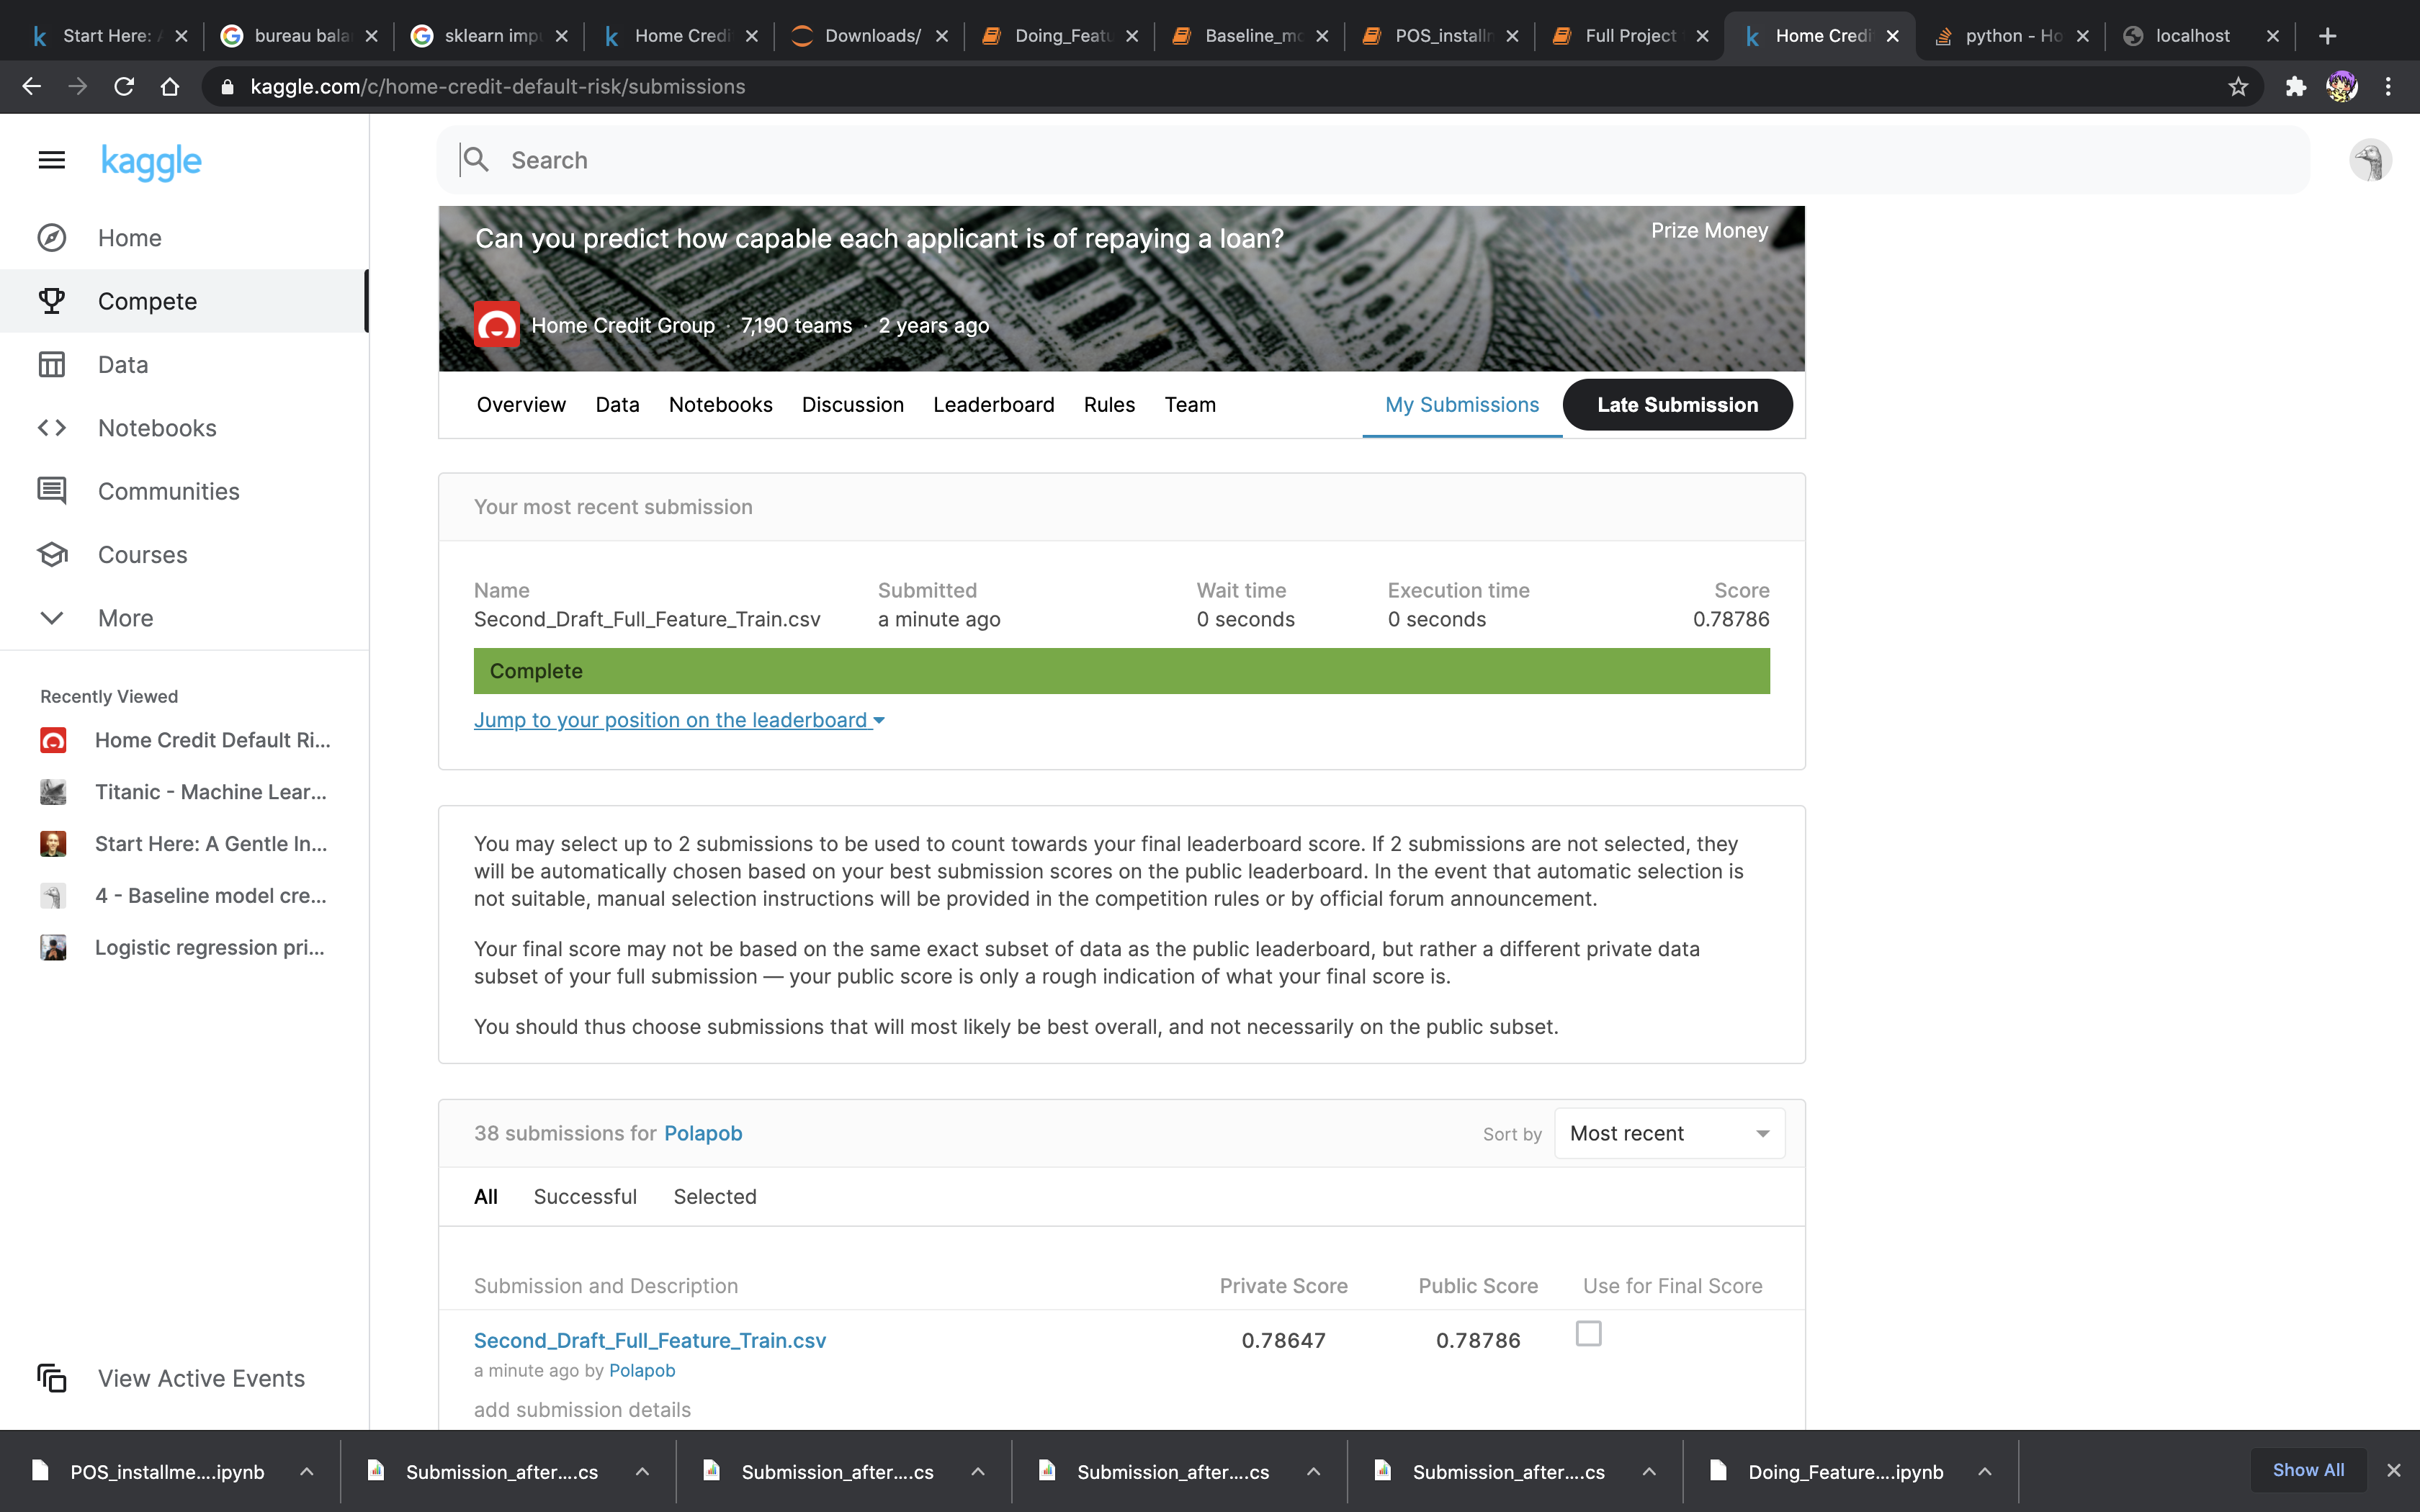

try to Scaling

In [159]:
train_data_final2.drop(columns="TARGET",inplace=True)

In [164]:
Sample_submission2 = Sample_submission.copy()

In [165]:
Sample_submission2["TARGET"] = submission2["TARGET"]
Sample_submission2.to_csv("Third_Draft_Full_Feature_Train.csv",index=False)